In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches


from pandas.plotting import scatter_matrix as splom

In [2]:
data = pd.read_csv('diabetes/diabetic_data_balanced.csv')
print(len(data.columns))
row_drop = data.loc[data.discharge_disposition_id == 11].index      # Drop patients who died from the data
row_drop.append(data.loc[data.discharge_disposition_id == 13].index)# Drop patients who were transferred to
row_drop.append(data.loc[data.discharge_disposition_id == 14].index)# another hospice from the data.
data.drop(row_drop, inplace=True, axis=0)
data.dropna(subset=['race'], inplace=True)            
# Cannot produce a meaningful filler value. Best to drop.

# Data exploration suggested that an indication of whether the glucose serum test was conducted at all might
# be more useful than tetrary feature.
data['booleanGlucose'] = list(map(int, (data.max_glu_serum != 'None')))

# Many possible values for discharge_disposition. Group them into internally similar groups.
def group_discharge(did):
    if did in [18,25,26]:
        return "NULL"
    elif did in [3,4,5]:
        return "ICF/SNF"
    elif did in [6,8,12]:
        return "Further Care at Home"
    elif did in [7]:
        return "Left A.M.A."
    else:
        return "Care Continues Elsewhere"
    
data['discharge_disposition_cat'] = data.discharge_disposition_id.map(group_discharge)
data['discharge_disposition_id'] = data.discharge_disposition_id.map(str)

# Same principle for Admission Source.
def group_ad_source(asid):
    if asid in [17,20,9]:
        return "NULL"
    elif asid in [1,2,3]:
        return "Referral"
    elif asid in [4,5,6]:
        return "Transfer"
    elif asid in [7]:
        return "E.R."
    elif asid in [8]:
        return "Law Enf."
    else:
        return "Other"

data['admission_source_cat'] = data.admission_source_id.map(group_ad_source)
data['admission_source_id'] = data.admission_source_id.map(str)

# Translate admission type to readable form + sanitise NULLs.
def transcribe_ad_t(atid):
    cats = [0, "Emergency","Urgent","Elective","Newborn", "", "NULL", "Trauma Center", ""]
    if atid in [5,6,8]:
        return "NULL"
    return cats[atid]

data['admission_type_cat'] = data.admission_type_id.map(transcribe_ad_t)
data['admission_type_id'] = data.admission_type_id.map(str)

# Get rid of the mess that the generics are.
# This tries to achieve the goal by creating 3 numerical features (one for each category except 'No') 
# that measures the number of instances of this category in the sample.
 
generics = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
            'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
            'miglitol', 'troglitazone', 'tolazamide', 'examide', 'insulin', 'glyburide-metformin', 
            'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
            'metformin-pioglitazone']

data['UP'] = np.sum([data[g] == 'Up' for g in generics], axis=0)
data['STEADY'] = np.sum([data[g] == 'Steady' for g in generics], axis=0)
data['DOWN'] = np.sum([data[g] == 'Down' for g in generics], axis=0)

# Age category lends itself to being made numerical. Update this feature accordingly.
data['age'] = data.age.map(lambda a: int(a[1]))

# We may find that the sum of total visits in the preceding year is more informative 
# than the three indivdual ones.
# We may then choose to cap at some value calculated based on the training set to obtain
# fewer values with more representation each.

data['total_visits'] = data.number_emergency + data.number_inpatient + data.number_outpatient


# Get a better representation for the diagnoses
def cat(diag):
    if (type(diag) == float and np.isnan(diag)) or diag == "NaN":
        return "NULL"
    try:
        num = int(diag)
    except Exception as e:
        if diag[0] == 'E':
            return "SUPP_CLASS_EXTERNAL_CAUSE"
        elif diag[0] == 'V':
            return "SUPP_CLASS_HEALTH_FACTORS"
        else:
            try:
                num = float(diag)
                return "DIABETES"
            except Exception as ex:
                return "ERROR"
    if (num >= 390 and num <= 459) or num == 785:
        return "CIRCULATORY"
    elif (num == 250):
        return "DIABETES"
    elif (num >= 460 and num <= 519) or num == 786:
        return "RESPIRATORY"
    elif (num >= 520 and num <= 579) or num == 787:
        return "DIGESTIVE"
    elif num >= 800: 
        return "INJURY_OR_POISON"
    elif num >= 710 and num <= 739:
        return "MUSKOSKELETAL"
    elif (num >= 580 and num <= 629) or num == 788:
        return "GENITOURINARY"
    elif num >= 140 and num <= 239:
        return "NEOPLASMS"
    elif num >= 680 and num <= 709:
        return "SKIN"
    elif num >= 780 and num <= 799:
        return "ILL-DEFINED"
    elif num <= 139:
        return "INFECTIOUS_PARASITIC"
    elif num >= 240 and num <= 279:
        return "ENDOCRINE_METABOLIC"
    elif num >= 290 and num <= 319:
        return "MENTAL_DISORDER"
    elif num >= 630 and num <= 679:
        return "PREGNANCY_COMPLICATIONS"
    elif num >= 280 and num <= 289:
        return "BLOOD"
    elif num >= 320 and num <= 389:
        return "NERVOUS_SENSE"
    elif num >= 740 and num <= 759:
        return "CONGENITAL"
    else: 
        return "ERROR"

data.race = data.race.map(lambda s: "African\nAmerican" if s == "AfricanAmerican" else s)
    
data['diagnoses'] = list(map(list, data[['diag_1', 'diag_2', 'diag_3']].values))
data['diagnoses'] = data.diagnoses.map(lambda l:[cat(i) for i in l if not (type(i)==float and np.isnan(i))])

data['diagnoses_nocat'] = list(map(list, data[['diag_1', 'diag_2', 'diag_3']].values))
data['diagnoses_nocat'] = data.diagnoses_nocat.map(lambda l:[i for i in l if not (type(i)==float and np.isnan(i))])

# Make data in `readmitted`, `max_glu_serum` and `A1Cresult` amicable to text rendering with latex...
rawconversion = {'NO' : r'NO', '>30' : ">30", '<30' : r"<30", 
                 '>7':'7-8', '>8' : r'$\geq 8$', '>200': '200-300', 
                 '>300':r'$\geq 300$', 'None':'None', 'Norm': 'Norm',
                 'No': 'No', 'Ch': 'Yes'}
data.readmitted = data.readmitted.map(rawconversion)
data.max_glu_serum = data.max_glu_serum.map(rawconversion)
data.A1Cresult = data.A1Cresult.map(rawconversion)

read_proportions = data.readmitted.value_counts()/len(data)

from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

data.sample(10)

50


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,booleanGlucose,discharge_disposition_cat,admission_source_cat,admission_type_cat,UP,STEADY,DOWN,total_visits,diagnoses,diagnoses_nocat
268,2957580,4845384,Caucasian,Female,7,NaN,6,25,7,2,...,0,NULL,E.R.,NULL,0,2,0,0,"[INJURY_OR_POISON, DIABETES, INJURY_OR_POISON]","[995, 250.6, 918]"
2256,14720478,599913,African\nAmerican,Female,3,NaN,1,1,7,2,...,0,Care Continues Elsewhere,E.R.,Emergency,0,0,0,0,"[RESPIRATORY, INFECTIOUS_PARASITIC, RESPIRATORY]","[786, 135, 517]"
2518,16395708,4030317,Caucasian,Male,4,NaN,1,1,7,1,...,0,Care Continues Elsewhere,E.R.,Emergency,0,0,0,1,"[DIGESTIVE, DIGESTIVE, ENDOCRINE_METABOLIC]","[571, 572, 250]"
1832,12018396,1945251,Caucasian,Female,5,NaN,2,1,20,1,...,0,Care Continues Elsewhere,NULL,Urgent,0,2,0,1,"[CIRCULATORY, RESPIRATORY, ENDOCRINE_METABOLIC]","[428, 496, 250]"
224,2792280,3306681,Caucasian,Male,5,NaN,6,25,1,1,...,0,NULL,Referral,NULL,0,1,0,0,"[CIRCULATORY, DIABETES, DIABETES]","[414, 250.6, 250.51]"
1525,10373022,7422984,African\nAmerican,Female,7,NaN,1,2,7,11,...,0,Care Continues Elsewhere,E.R.,Emergency,0,0,1,1,"[CIRCULATORY, CIRCULATORY, CIRCULATORY]","[434, 403, 433]"
9932,92770650,21641751,Caucasian,Male,4,NaN,1,1,7,1,...,0,Care Continues Elsewhere,E.R.,Emergency,0,1,0,0,"[ENDOCRINE_METABOLIC, RESPIRATORY]","[250, 786]"
129,2223336,558360,African\nAmerican,Female,6,NaN,6,25,1,9,...,0,NULL,Referral,NULL,0,0,0,0,"[INJURY_OR_POISON, INFECTIOUS_PARASITIC, MUSKO...","[997, 8, 730]"
3731,22449504,106752348,Caucasian,Female,3,NaN,3,6,2,14,...,0,Further Care at Home,Referral,Elective,1,0,0,1,"[INJURY_OR_POISON, SKIN, INJURY_OR_POISON]","[942, 682, 958]"
7500,37904346,1132776,Caucasian,Female,8,NaN,1,6,7,4,...,0,Further Care at Home,E.R.,Emergency,0,1,0,0,"[MENTAL_DISORDER, CIRCULATORY, SUPP_CLASS_HEAL...","[290, 427, V45]"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 9997
Data columns (total 60 columns):
encounter_id                 9693 non-null int64
patient_nbr                  9693 non-null int64
race                         9693 non-null object
gender                       9693 non-null object
age                          9693 non-null int64
weight                       281 non-null object
admission_type_id            9693 non-null object
discharge_disposition_id     9693 non-null object
admission_source_id          9693 non-null object
time_in_hospital             9693 non-null int64
payer_code                   214 non-null object
medical_specialty            6197 non-null object
num_lab_procedures           9693 non-null int64
num_procedures               9693 non-null int64
num_medications              9693 non-null int64
number_outpatient            9693 non-null int64
number_emergency             9693 non-null int64
number_inpatient             9693 non-null int64
diag_

None          8784
Norm           426
200-300        266
$\geq 300$     217
Name: max_glu_serum, dtype: int64


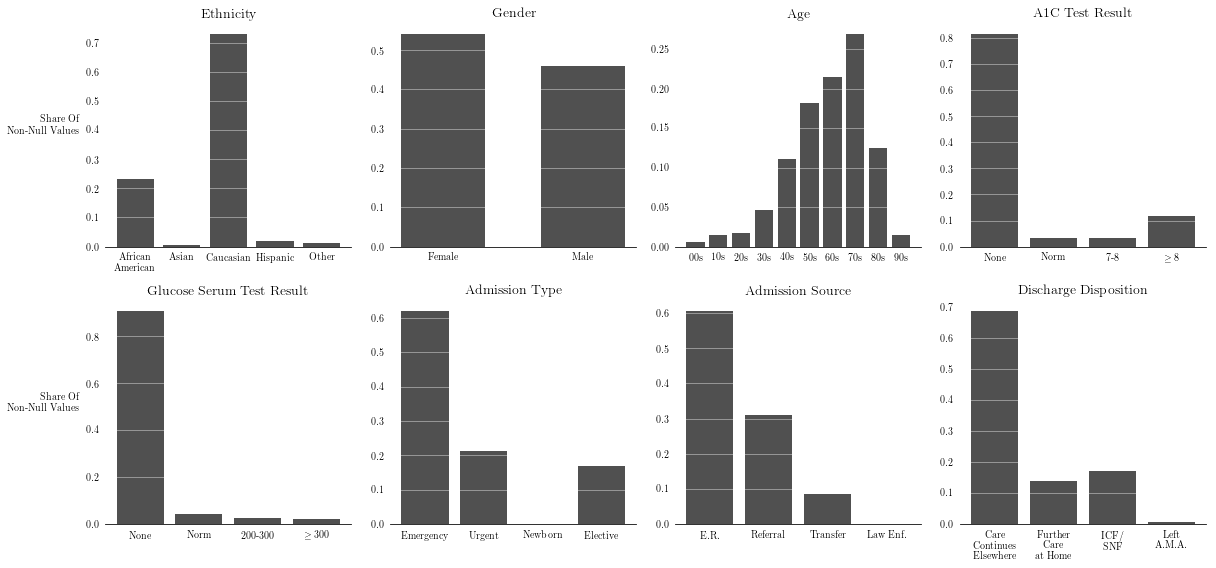

In [7]:
fig, axes = plt.subplots(2,4, figsize=(17,8), sharey=False)
axes = axes.reshape((-1))

data['raceandgender'] = data.race + data.gender

ethnicity_counts_lt = data.loc[data.readmitted == '<30'].race.value_counts().sort_index()
ethnicity_counts_gt = data.loc[data.readmitted == '>30'].race.value_counts().sort_index()
ethnicity_counts_no = data.loc[data.readmitted == 'NO'].race.value_counts().sort_index()
ethnicity_counts = ethnicity_counts_lt + ethnicity_counts_gt + ethnicity_counts_no
norm_eth  = ethnicity_counts.sum()
ethnicity_counts_gt /= norm_eth; ethnicity_counts_lt /= norm_eth; ethnicity_counts_no /= norm_eth
ethnicity_counts /= norm_eth
axes[0].bar(range(len(ethnicity_counts)), ethnicity_counts.values, fc='#505050', label=r'$<30$')
axes[0].set_xticks(range(len(ethnicity_counts)))
axes[0].set_xticklabels(ethnicity_counts.keys(), horizontalalignment='center', rotation=0)
axes[0].set_title('Ethnicity', fontsize=14)
axes[0].set_ylabel('Share Of\nNon-Null Values', rotation=0, horizontalalignment='right', labelpad=7)
axes[4].set_ylabel('Share Of\nNon-Null Values', rotation=0, horizontalalignment='right', labelpad=7)

gender_counts_lt = data.loc[data.readmitted == '<30'].gender.value_counts().sort_index()
gender_counts_gt = data.loc[data.readmitted == '>30'].gender.value_counts().sort_index()
gender_counts_no = data.loc[data.readmitted == 'NO'].gender.value_counts().sort_index()
gender_counts = gender_counts_lt + gender_counts_gt + gender_counts_no
norm_gen = gender_counts.sum()
gender_counts_gt /= norm_gen; gender_counts_lt /= norm_gen; gender_counts_no /= norm_gen
gender_counts /= norm_gen
axes[1].bar(range(len(gender_counts)), gender_counts.values, fc='#505050', label='<30', width=0.6)
axes[1].set_xticks(range(len(gender_counts)))
axes[1].set_xticklabels(gender_counts.keys(), rotation=0)
axes[1].set_title('Gender', fontsize=14)

age_counts_lt = data.loc[data.readmitted=='<30'].age.value_counts().sort_index()
age_counts_gt = data.loc[data.readmitted=='>30'].age.value_counts().sort_index()
age_counts_no = data.loc[data.readmitted=='NO'].age.value_counts().sort_index()
age_counts = age_counts_no + age_counts_gt + age_counts_lt
norm_age = age_counts.sum()
age_counts_gt /= norm_age; age_counts_lt /= norm_age; age_counts_no /= norm_age
age_counts /= norm_age
axes[2].bar(range(len(age_counts)), age_counts.values, fc='#505050', label='NO')
axes[2].set_xticks(range(len(age_counts)))
axes[2].set_xticklabels(map(lambda i: f'{10*i:0=2d}s', age_counts.keys()), 
                        rotation=0, horizontalalignment='center')
axes[2].set_title('Age', fontsize=14)

a1c_counts_lt = data.loc[data.readmitted=='<30'].A1Cresult.value_counts().sort_index()[[2,3,1,0]]
a1c_counts_gt = data.loc[data.readmitted=='>30'].A1Cresult.value_counts().sort_index()[[2,3,1,0]]
a1c_counts_no = data.loc[data.readmitted=='NO'].A1Cresult.value_counts().sort_index()[[2,3,1,0]]
a1c_counts = a1c_counts_no + a1c_counts_gt + a1c_counts_lt
norm_a1c = a1c_counts.sum()
a1c_counts_gt /= norm_a1c; a1c_counts_lt /= norm_a1c; a1c_counts_no /= norm_a1c
a1c_counts /= norm_a1c
axes[3].bar(range(len(a1c_counts)), a1c_counts.values, fc='#505050', label='NO')
axes[3].set_xticks(range(len(a1c_counts)))
axes[3].set_xticklabels(a1c_counts.keys(), rotation=0)
axes[3].set_title('A1C Test Result', fontsize=14)

glu_counts_lt = data.loc[data.readmitted=='<30'].max_glu_serum.value_counts().sort_index()[[2,3,1,0]]
glu_counts_gt = data.loc[data.readmitted=='>30'].max_glu_serum.value_counts().sort_index()[[2,3,1,0]]
glu_counts_no = data.loc[data.readmitted=='NO'].max_glu_serum.value_counts().sort_index()[[2,3,1,0]]
glu_counts = glu_counts_no + glu_counts_gt + glu_counts_lt
print(glu_counts)
norm_glu = glu_counts.sum()
glu_counts_gt /= norm_glu; glu_counts_lt /= norm_glu; glu_counts_no /= norm_glu
glu_counts /= norm_glu
axes[4].bar(range(len(glu_counts)), glu_counts.values, fc='#505050', label='<30')
axes[4].set_xticks(range(len(glu_counts)))
axes[4].set_xticklabels(glu_counts.keys(), rotation=0)
axes[4].set_title('Glucose Serum Test Result', fontsize=14)

change_counts_lt = data.loc[data.readmitted=='<30'].admission_type_cat.value_counts().sort_index()[[1,4,3,0]]
change_counts_gt = data.loc[data.readmitted=='>30'].admission_type_cat.value_counts().sort_index()[[1,4,3,0]]
change_counts_no = data.loc[data.readmitted=='NO'].admission_type_cat.value_counts().sort_index()[[1,4,3,0]]
change_counts = change_counts_no + change_counts_gt + change_counts_lt
norm_change = change_counts.sum()
change_counts_gt /= norm_change; change_counts_lt /= norm_change; change_counts_no /= norm_change
change_counts /= norm_change
axes[5].bar(range(len(change_counts)), change_counts.values, fc='#505050', label='<30')
axes[5].set_xticks(range(len(change_counts)))
axes[5].set_xticklabels(change_counts.keys(), rotation=0, horizontalalignment='center')
axes[5].set_title('Admission Type', fontsize=14)

change_counts = data.admission_source_cat.value_counts().sort_index()[[0,3,4,1]]
norm_change = change_counts.sum()
change_counts_gt /= norm_change; change_counts_lt /= norm_change; change_counts_no /= norm_change
change_counts /= norm_change
axes[6].bar(range(len(change_counts)), change_counts.values, fc='#505050', label='<30')
axes[6].set_xticks(range(len(change_counts)))
axes[6].set_xticklabels(map(lambda s: s, change_counts.keys()), rotation=0, horizontalalignment='center')
axes[6].set_title('Admission Source', fontsize=14)

change_counts_lt = data.loc[data.readmitted=='<30'].discharge_disposition_cat.value_counts().sort_index()[:-1]
change_counts_gt = data.loc[data.readmitted=='>30'].discharge_disposition_cat.value_counts().sort_index()[:-1]
change_counts_no = data.loc[data.readmitted=='NO'].discharge_disposition_cat.value_counts().sort_index()[:-1]
change_counts = change_counts_no + change_counts_gt + change_counts_lt
norm_change = change_counts.sum()
change_counts_gt /= norm_change; change_counts_lt /= norm_change; change_counts_no /= norm_change
change_counts /= norm_change
axes[7].bar(range(len(change_counts)), change_counts.values, fc='#505050', label='<30')
axes[7].set_xticks(range(len(change_counts)))
axes[7].set_xticklabels(map(lambda s: s.replace(' ', '\n', 2).replace('/', '/\n'), change_counts.keys()), rotation=0, horizontalalignment='center')
axes[7].set_title('Discharge Disposition', fontsize=14)

for ax in axes:
#    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', color='white', grid_color='black', grid_alpha=1)
    ax.tick_params(axis='x', color='white', grid_color='black', grid_alpha=1)
    ax.grid(which='major', color='w', linestyle='-', axis='y', alpha=0.5)
    
colours = ["#e7e1ef","#c994c7","#dd1c77"]
labels = ['NO', r'$>30$', r'$<30$']

fig.tight_layout() 

plt.savefig('distributions.pdf')

plt.show()

In [422]:
asians = data.loc[data.race == 'Asian']
print(len(asians), "Asians in the data set.")
for k, v in zip(asians.readmitted.value_counts().index, asians.readmitted.value_counts().values):
    print(k+":", v)
print()

latinx = data.loc[data.race == 'Hispanic']
print(len(latinx), "Hispanics in the data set.")
for k, v in zip(latinx.readmitted.value_counts().index, latinx.readmitted.value_counts().values):
    print(k+":", v)
print()

other = data.loc[data.race == 'Other']
print(len(other), "Others in the data set.")
for k, v in zip(other.readmitted.value_counts().index, other.readmitted.value_counts().values):
    print(k+":", v)
print()

black_counts = data.loc[data.race == "African American"].readmitted.value_counts()
print(black_counts / black_counts.sum())
white_counts = data.loc[data.race == "Caucasian"].readmitted.value_counts()
print(white_counts / white_counts.sum())

print(193/len(data))

42 Asians in the data set.
<30: 16
NO: 14
>30: 12

193 Hispanics in the data set.
<30: 79
>30: 71
NO: 43

129 Others in the data set.
NO: 59
<30: 37
>30: 33

Series([], Name: readmitted, dtype: float64)
<30    0.339737
>30    0.333804
NO     0.326459
Name: readmitted, dtype: float64
0.019911276178685648


5
5
5

2
2
2

10
10
10

4
4
4

4
4
4

4
4
4

4
4
4

4
4
4



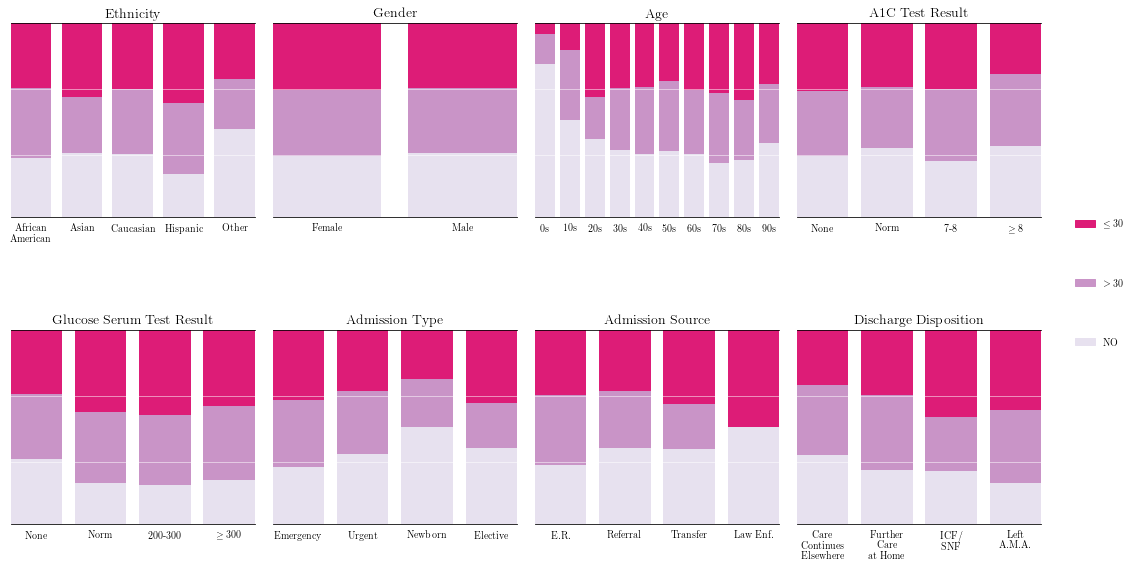

In [423]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey='row')

axes = axes.reshape(-1)

for ax in axes:
    ax.set_yticks([])
    #ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
colours = ["#e7e1ef","#c994c7","#dd1c77"]
labels = ['NO', r'$>30$', r'$\leq 30$']

features = [(data.race, 'Ethnicity', None), 
            (data.gender, 'Gender', None),
            (data.age, 'Age', None),
            (data.A1Cresult, 'A1C Test Result', [2,3,1,0]),
            (data.max_glu_serum, 'Glucose Serum Test Result', [2,3,1,0]),
            (data.admission_type_cat, 'Admission Type', [1,4,3,0]),
            (data.admission_source_cat, 'Admission Source', [0,3,4,1]),
            (data.discharge_disposition_cat, 'Discharge Disposition', [0,1,2,3])]

for i, (ax, (ds, title, idx)) in enumerate(zip(axes, features)):
    cats = list(ds.value_counts().sort_index().index)
    idx = idx if idx != None else list(range(len(cats)))
    ethnicity_counts_lt = ds.loc[data.readmitted == '<30'].value_counts().sort_index()
    ethnicity_counts_gt = ds.loc[data.readmitted == '>30'].value_counts().sort_index()
    ethnicity_counts_no = ds.loc[data.readmitted == 'NO'].value_counts().sort_index()
    for cat in cats:
        if cat == 'NULL':
            cats.remove(cat)
            continue
        for cs in (ethnicity_counts_gt, ethnicity_counts_lt, ethnicity_counts_no):
            if not cat in cs.index: 
                cs[cat] = 0
    ethnicity_counts_lt = ethnicity_counts_lt.sort_index()[idx]
    ethnicity_counts_gt = ethnicity_counts_gt.sort_index()[idx]
    ethnicity_counts_no = ethnicity_counts_no.sort_index()[idx]
    
    ethnicity_freqs = np.sum([ethnicity_counts_gt, ethnicity_counts_lt, ethnicity_counts_no], axis=0)
    print(len(cats))
    print(len(ethnicity_counts_no))
    print(len(ethnicity_freqs))
    print()
    ax.bar(range(len(cats)), ethnicity_counts_no / ethnicity_freqs, color="#e7e1ef", label='NO')
    ax.bar(range(len(cats)), ethnicity_counts_gt / ethnicity_freqs, color="#c994c7", label='>30', bottom=ethnicity_counts_no / ethnicity_freqs)
    ax.bar(range(len(cats)), ethnicity_counts_lt / ethnicity_freqs, color="#dd1c77", label='<30', bottom=(ethnicity_counts_no+ethnicity_counts_gt) / ethnicity_freqs)
    ax.set_xticks(range(len(cats)))
    if title=='Age':
        ax.set_xticklabels(map(lambda x: f"{10*x}s", ethnicity_counts_no.keys()), rotation=0, horizontalalignment='center')
    else:
        ax.set_xticklabels(ethnicity_counts_no.keys(), rotation=0, horizontalalignment='center')
    ax.plot([-10,36], [read_proportions['NO'],read_proportions['NO']], 'w', linewidth=0.5)
    ax.plot([-10,36], [1-read_proportions[r'<30'],1-read_proportions[r'<30']], 'w', linewidth=0.5)
    ax.set_ylim(0,1)
    ax.set_xlim(-.4,len(cats)-.6)
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis='x', color='white', grid_color='black', grid_alpha=1)
    
l = plt.legend(handles=list(map(lambda p : mpatches.Patch(color=p[0], label=p[1]), zip(colours, labels)))[::-1],
          bbox_to_anchor=(0.925, 0.5), loc='center left', borderaxespad=1, labelspacing=5, frameon=False, bbox_transform=fig.transFigure)

axes[7].set_xticklabels(map(lambda s: s.replace(' ', '\n', 2).replace('/', '/\n'), change_counts.keys()), rotation=0, horizontalalignment='center')
    
fig.tight_layout()
plt.savefig('proportions.pdf', bbox_extra_artists=[l])
plt.show()

In [413]:
distinct = len(data.diag_1.value_counts())
print("Number of distinct values for Diagnosis 1:", distinct)
print("Of these there was only one one instance of:", len(data.diag_1.value_counts().loc[data.diag_1.value_counts() == 1]))
total = data.diag_1.value_counts().sum()
tencommon = data.diag_1.value_counts()[:18].sum()

print(f"The 18 most common diagnoses make for {tencommon} out of {total} diagnoses. ({100*tencommon/total:.4}%)")
nums = []
percs = []
for i in range(1,5):
    num = data.diag_1.value_counts().value_counts().sort_index()[i]
    nums.append(num)
    perc = 100*i*num/total
    percs.append(perc)
    print(f"The diagnoses that were made only {i} times account for {num*i} out of {total} diagnoses. ({perc:.4}%)")
    print(f"This encompasses {num} distinct diagnoses, out of {distinct}. ({100*num/distinct:.3}%)")
    print()
print(f"Overall, the diagnoses that were made fewer than 5 times account for {100*sum(nums)/distinct:.3}% of the distinct values and {sum(percs):.3}% of all diagnoses.")

Number of distinct values for Diagnosis 1: 441
Of these there was only one one instance of: 112
The 18 most common diagnoses make for 5054 out of 9994 diagnoses. (50.57%)
The diagnoses that were made only 1 times account for 112 out of 9994 diagnoses. (1.121%)
This encompasses 112 distinct diagnoses, out of 441. (25.4%)

The diagnoses that were made only 2 times account for 108 out of 9994 diagnoses. (1.081%)
This encompasses 54 distinct diagnoses, out of 441. (12.2%)

The diagnoses that were made only 3 times account for 126 out of 9994 diagnoses. (1.261%)
This encompasses 42 distinct diagnoses, out of 441. (9.52%)

The diagnoses that were made only 4 times account for 100 out of 9994 diagnoses. (1.001%)
This encompasses 25 distinct diagnoses, out of 441. (5.67%)

Overall, the diagnoses that were made fewer than 5 times account for 52.8% of the distinct values and 4.46% of all diagnoses.


In [222]:
picks1 = data.diag_1.map(lambda x : x in data.diag_1.value_counts().loc[data.diag_1.value_counts() == 1].index)
picks2 = data.diag_1.map(lambda x : x in data.diag_1.value_counts().loc[data.diag_1.value_counts() == 2].index)
picks3 = data.diag_1.map(lambda x : x in data.diag_1.value_counts().loc[data.diag_1.value_counts() == 3].index)
picks4 = data.diag_1.map(lambda x : x in data.diag_1.value_counts().loc[data.diag_1.value_counts() == 4].index)
picks5 = data.diag_1.map(lambda x : x in data.diag_1.value_counts().loc[data.diag_1.value_counts() == 5].index)
picks = [picks1, picks2, picks3, picks4, picks5]

Diagnoses made 1 times
<30    27
>30    36
NO     49
Name: readmitted, dtype: int64

Diagnoses made 2 times
<30    38
>30    39
NO     31
Name: readmitted, dtype: int64

Diagnoses made 3 times
<30    35
>30    36
NO     55
Name: readmitted, dtype: int64

Diagnoses made 4 times
<30    34
>30    26
NO     40
Name: readmitted, dtype: int64

Diagnoses made 5 times
<30    25
>30    25
NO     20
Name: readmitted, dtype: int64



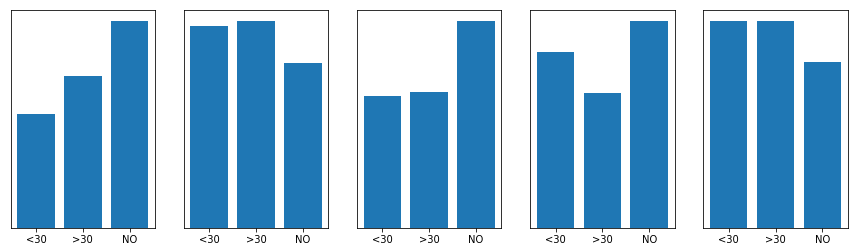

In [244]:
fig, axes = plt.subplots(1,5 , figsize=(15, 4))
axes = axes.reshape(-1)
for i, pick in enumerate(picks):          
    counts = data.loc[pick].readmitted.value_counts().sort_index()
    ax = axes[i]
    ax.bar([0,1,2], counts.values)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(counts.index)
    ax.set_yticks([])
    print(f"Diagnoses made {i+1} times")
    print(counts)
    print()
plt.show()    

Diag 1: 428
691 719 487 total: 1897
Total Variation Distance: 0.07661
Η: -1.565; ΔΗ: 0.02014

Diag 2: 250
470 541 703 total: 1714
Total Variation Distance: 0.07682
Η: -1.564; ΔΗ: 0.02063

Diag 3: 414
429 569 626 total: 1624
Total Variation Distance: 0.06917
Η: -1.568; ΔΗ: 0.01737

Diag 4: 401
348 390 488 total: 1226
Total Variation Distance: 0.06471
Η: -1.57; ΔΗ: 0.01462

Diag 5: 276
388 347 365 total: 1100
Total Variation Distance: 0.01939
Η: -1.583; ΔΗ: 0.001508

Diag 6: 427
328 293 322 total: 943
Total Variation Distance: 0.02262
Η: -1.583; ΔΗ: 0.001723

Diag 7: 496
229 197 190 total: 616
Total Variation Distance: 0.03842
Η: -1.58; ΔΗ: 0.004855

Diag 8: 250.01
200 210 203 total: 613
Total Variation Distance: 0.009244
Η: -1.585; ΔΗ: 0.0003024

Diag 9: 403
242 216 127 total: 585
Total Variation Distance: 0.1162
Η: -1.536; ΔΗ: 0.04905

Diag 10: 599
189 202 179 total: 570
Total Variation Distance: 0.02105
Η: -1.583; ΔΗ: 0.001768

Diag 11: 786
136 184 175 total: 495
Total Variation Dista

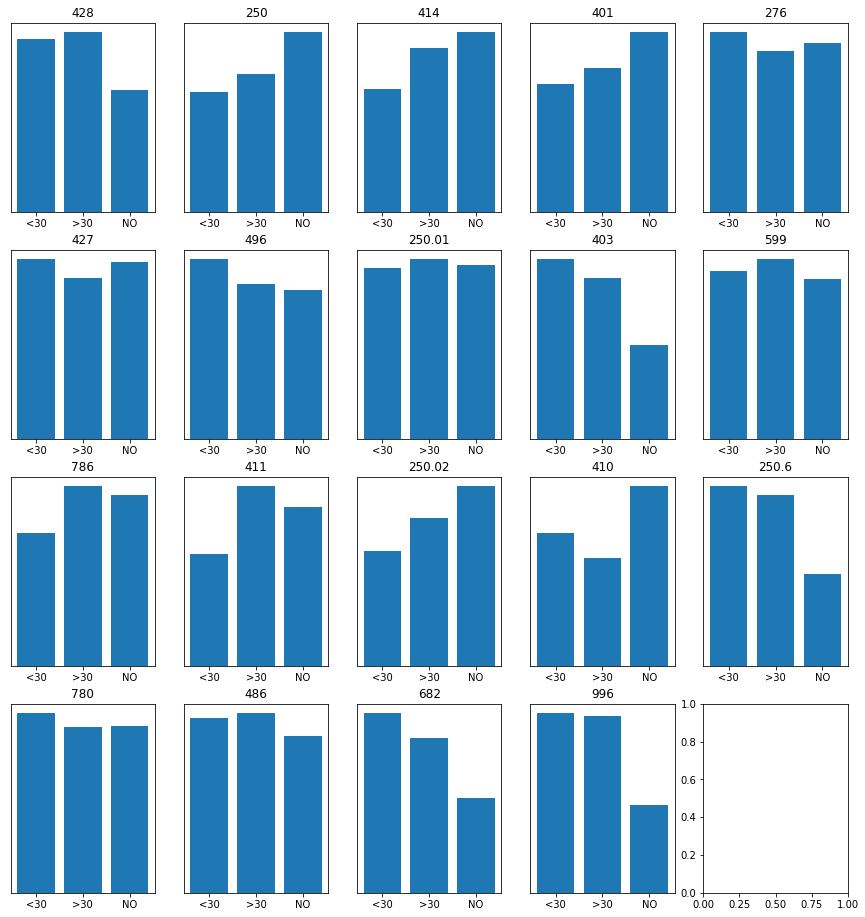

In [532]:
total_var = lambda counts: abs(np.array(counts / counts.sum()) - 1/3).sum() / 2
p = lambda counts: counts/counts.sum()
Η = lambda counts: np.log2(p(counts)) @ (p(counts))
Δ = lambda counts: Η(counts) + np.log2(3)

fig, axes = plt.subplots(4,5 , figsize=(15, 16))
axes = axes.reshape(-1)
ent_change = 0
for i, diag in enumerate(all_diags.value_counts().index[:19]):          # Consider the 19 most common diagnoses
    choices = map(any, zip(data.diag_1 == diag, data.diag_2 == diag, data.diag_3 == diag))
    counts = data.loc[choices].readmitted.value_counts().sort_index()
    ax = axes[i]
    ax.set_title(diag)
    ax.bar([0,1,2], counts.values)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(counts.index)
    ax.set_yticks([])
    print(f"Diag {i+1}:", diag)
    print(counts['<30'], counts['>30'], counts['NO'], f"total: {sum(counts)}")
    print(f"Total Variation Distance: {total_var(counts):.4}")
    print(f"Η: {Η(counts):.4}; ΔΗ: {Δ(counts):.4}")
    if Δ(counts) > Δ(np.array([1/3+0.1, 1/3-0.1, 1/3])):
        ent_change +=1
    print()
print(f"A total of {ent_change} of these diagnoses exhibit a change in entropy")

plt.show()

In [667]:
from tqdm import tqdm_notebook as tqdm
thresh_favours = dict([])

all_diags = data.diag_1.append(data.diag_2.append(data.diag_3))

for thresh in tqdm(np.linspace(0.05, 0.2, 50)):
    ent_change = 0
    tv_change = 0

    favours = dict([('none', 0)] + list(np.reshape([[(f'{v} {t}', [])] for v in ['favours', 'disfavours'] for t in ['NO', '>30', '<30']], (-1,2))))
    favours = dict([(k, []) for k,v in favours.items()])
    count = 0
    for i, diag in enumerate(all_diags.value_counts().index[all_diags.value_counts() >= 15]):# Consider the 10 most common diagnoses
        choices = map(any, zip(data.diag_1 == diag, data.diag_2 == diag, data.diag_3 == diag))
        counts = data.loc[choices].readmitted.value_counts().sort_index()    
        for t in ['NO', '>30', '<30']:
            if not (t in counts.index):
                counts = counts.append(pd.Series({t:0}))
        counts = counts.sort_index()
        tv = total_var(counts)
        delta = Δ(counts)
        if delta > Δ(np.array([1/3 + thresh, 1/3 - thresh/2, 1/3-thresh/2])):
            ent_change +=1
        if tv > thresh:
            tv_change +=1
            if (counts/counts.sum()-1/3 *np.ones(3)).idxmax() ==  np.abs((counts/counts.sum()-1/3 *np.ones(3))).idxmax():
                favours['favours '+counts.idxmax()].append(diag)
            else:
                favours[f'disfavours {counts.idxmin()}'].append(diag)
        else:
            favours['none'].append(diag)
        favours['none'].extend(all_diags.value_counts().index[all_diags.value_counts() < 15])
        count+=1
    print(f"A total of {ent_change} of the {count} diagnoses made at least 15 times exhibit a change in entropy")
    print(f"A total of {tv_change} of the {count} diagnoses made at least 15 times exhibit a change in tv distance")
    thresh_favours[thresh] = favours

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


A total of 180 of the 213 diagnoses made at least 15 times exhibit a change in entropy
A total of 178 of the 213 diagnoses made at least 15 times exhibit a change in tv distance
A total of 178 of the 213 diagnoses made at least 15 times exhibit a change in entropy
A total of 177 of the 213 diagnoses made at least 15 times exhibit a change in tv distance
A total of 175 of the 213 diagnoses made at least 15 times exhibit a change in entropy
A total of 173 of the 213 diagnoses made at least 15 times exhibit a change in tv distance
A total of 175 of the 213 diagnoses made at least 15 times exhibit a change in entropy
A total of 171 of the 213 diagnoses made at least 15 times exhibit a change in tv distance
A total of 173 of the 213 diagnoses made at least 15 times exhibit a change in entropy
A total of 170 of the 213 diagnoses made at least 15 times exhibit a change in tv distance
A total of 168 of the 213 diagnoses made at least 15 times exhibit a change in entropy
A total of 166 of the 2

A total of 42 of the 213 diagnoses made at least 15 times exhibit a change in entropy
A total of 34 of the 213 diagnoses made at least 15 times exhibit a change in tv distance
A total of 40 of the 213 diagnoses made at least 15 times exhibit a change in entropy
A total of 32 of the 213 diagnoses made at least 15 times exhibit a change in tv distance
A total of 40 of the 213 diagnoses made at least 15 times exhibit a change in entropy
A total of 30 of the 213 diagnoses made at least 15 times exhibit a change in tv distance



In [694]:
impurities_fno = []
impurities_fgt = []
impurities_flt = []
impurities_dno = []
impurities_dgt = []
impurities_dlt = []
coverages = []
diags = list(zip(data.diag_1, data.diag_2, data.diag_3))

for thresh in tqdm(np.linspace(0.05, 0.2, 50)):
    diag_to_favour = dict([(diag, favour)  for favour, diagnoses in thresh_favours[thresh].items() for diag in diagnoses])
    prefs = list(map(lambda x: list(map(lambda y: diag_to_favour[y] , list(filter(lambda z: not type(z)==float, x)))), diags))
    def choices(gold):
        tmp = []
        for ps in prefs:
            votes, vote_counts = np.unique(ps, return_counts=True)
            tmp.append(votes[vote_counts.argmax()] == gold)
        return tmp
    nos = choices('favours NO')
    lts = choices('favours <30')
    gts = choices('favours >30')
    notnos = choices('disfavours NO')
    notlts = choices('disfavours <30')
    notgts = choices('disfavours >30')
    predictions_no = data.loc[nos].readmitted.value_counts()
    predictions_gt = data.loc[gts].readmitted.value_counts()
    predictions_lt = data.loc[lts].readmitted.value_counts()
    predictions_nno = data.loc[notnos].readmitted.value_counts()
    predictions_ngt = data.loc[notgts].readmitted.value_counts()
    predictions_nlt = data.loc[notlts].readmitted.value_counts()
    
    impurities_fno.append(1 - ((predictions_no/data.loc[nos].readmitted.value_counts().sum())**2).sum())
    impurities_fgt.append(1 - ((predictions_gt/data.loc[gts].readmitted.value_counts().sum())**2).sum())
    impurities_flt.append(1 - ((predictions_lt/data.loc[lts].readmitted.value_counts().sum())**2).sum())
    impurities_dno.append(1 - ((predictions_nno/data.loc[notnos].readmitted.value_counts().sum())**2).sum())
    impurities_dgt.append(1 - ((predictions_ngt/data.loc[notgts].readmitted.value_counts().sum())**2).sum())
    impurities_dlt.append(1 - ((predictions_nlt/data.loc[notlts].readmitted.value_counts().sum())**2).sum())
    if(impurities_dlt[-1] < 0):
        print(1-(predictions_lt/data.loc[notlts].readmitted.value_counts().sum())**2)
        print(data.loc[notlts].readmitted.value_counts().sum())
        print(predictions_)
    coverages.append(sum(map(sum, [predictions_no, predictions_gt, predictions_lt,predictions_nno, predictions_ngt, predictions_nlt]))/len(data))

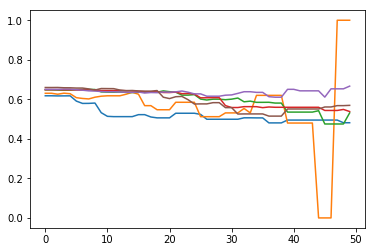

In [700]:
plt.plot(impurities_fno)
plt.plot(impurities_fgt)
plt.plot(impurities_flt)
plt.plot(impurities_dno)
plt.plot(impurities_dgt)
plt.plot(impurities_dlt)


In [692]:
1-((predictions_lt/data.loc[notlts].readmitted.value_counts().sum())**2).sum()

0.16666666666666663

In [555]:
all_diags = data.diag_1.append(data.diag_2.append(data.diag_3))
all_diags.value_counts()[int(len(all_diags.value_counts())/2.84):].sum() / all_diags.value_counts().sum()

0.050013462574044154

In [659]:
data.diag_3.value_counts()['V27']

6

In [582]:
a= zip(data.diag_1, data.diag_2, data.diag_3)
next(a)

('250.83', nan, nan)

In [779]:
print(ethnicity_counts)
print(ethnicity_counts['Caucasian'])
print(ethnicity_counts[2])
print(ethnicity_counts[[2,3,0,1,4]])

AfricanAmerican    0.231286
Asian              0.004277
Caucasian          0.731337
Hispanic           0.019859
Other              0.013240
Name: race, dtype: float64
0.7313372033811997
0.7313372033811997
Caucasian          0.731337
Hispanic           0.019859
AfricanAmerican    0.231286
Asian              0.004277
Other              0.013240
Name: race, dtype: float64


In [613]:
np.unique(np.array(list(l), dtype=object), return_counts=True)

(array([False, True], dtype=object), array([1, 2]))

In [611]:
np.array(list(l), dtype=object)

array([], dtype=object)

In [623]:
np.isnan(np.nan)

True

In [628]:
list(filter(lambda z: not np.isnan(z), [1, 2, np.nan, 3]))

[1, 2, 3]

In [642]:
a = map(lambda x: map(lambda y: diag_to_favour[y], list(filter(lambda z: not type(z) == float, x))), diags)

In [815]:
axes[4].get_ylim()

(0.0, 1.841042006242687e+43)

In [641]:
type(np.nan)

float

In [1132]:
['metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone']

['metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone']

In [853]:
medicine_counts_no

Down       291
No        1755
Steady    1095
Up         192
Name: insulin, dtype: int64

No Up in 0 (glimepiride-pioglitazone)
No Down in 0 (glimepiride-pioglitazone)
No Steady in 0 (glimepiride-pioglitazone)
No Up in 1 (glimepiride-pioglitazone)
No Down in 1 (glimepiride-pioglitazone)
No Steady in 1 (glimepiride-pioglitazone)
No Up in 2 (glimepiride-pioglitazone)
No Down in 2 (glimepiride-pioglitazone)
No Steady in 2 (glimepiride-pioglitazone)
No Up in 0 (chlorpropamide)
No Down in 0 (chlorpropamide)
No Up in 1 (chlorpropamide)
No Down in 1 (chlorpropamide)
No Up in 2 (chlorpropamide)
No Down in 2 (chlorpropamide)
No Up in 0 (glyburide-metformin)
No Down in 0 (glyburide-metformin)
No Up in 1 (glyburide-metformin)
No Down in 1 (glyburide-metformin)
No Steady in 1 (glyburide-metformin)
No Up in 2 (glyburide-metformin)
No Down in 2 (glyburide-metformin)


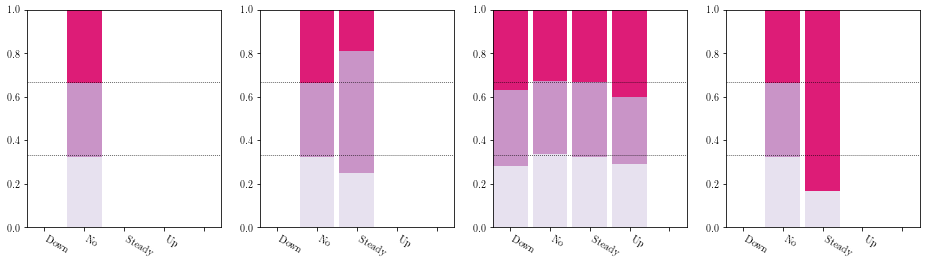

In [1229]:
fig, axes = plt.subplots(1,4, figsize=(16, 4))
medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
for i, medication in enumerate(np.random.choice(medications, 4)):
    medicine_counts_lt = data.loc[data.readmitted == '<30'][medication].value_counts().sort_index()
    medicine_counts_gt = data.loc[data.readmitted == '>30'][medication].value_counts().sort_index()
    medicine_counts_no = data.loc[data.readmitted == 'NO'][medication].value_counts().sort_index()
    for j, ms in enumerate([medicine_counts_lt, medicine_counts_gt, medicine_counts_no]):
        for m in ['Up', 'Down', 'Steady', 'No']:
            if not m in ms.index:
                ms[m] = 0
                print("No", m, "in", j, f"({medication})")
    for ms in [medicine_counts_lt, medicine_counts_gt, medicine_counts_no]:
        ms.sort_index(inplace=True)
    medicine_counts = medicine_counts_lt + medicine_counts_gt + medicine_counts_no
    norm_medicine  = medicine_counts.sum()
    
    medicine_freqs = np.sum([medicine_counts_gt, medicine_counts_lt, medicine_counts_no], axis=0)
    axes[i].bar(range(1,9,2), medicine_counts_no / medicine_freqs, color="#e7e1ef", label='NO', width=1.75)
    axes[i].bar(range(1,9,2), medicine_counts_gt / medicine_freqs, color="#c994c7", label='>30',width=1.75, bottom=medicine_counts_no /medicine_freqs)
    axes[i].bar(range(1,9,2), medicine_counts_lt / medicine_freqs, color="#dd1c77", label='<30',width=1.75, bottom=(medicine_counts_no+medicine_counts_gt) / medicine_freqs)
    axes[i].set_xticks(range(1,10,2))
    axes[i].set_xticklabels(medicine_counts_no.keys(), rotation=-30, horizontalalignment='left')
    axes[i].plot([0,36], [1/3, 1/3], 'k:', linewidth=0.75)
    axes[i].plot([0,36], [2/3, 2/3], 'k:', linewidth=0.75)
    axes[i].set_ylim(0,1)
    axes[i].set_xlim(1-1.75/2,9+1.75/2)

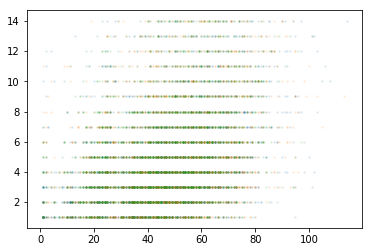

In [904]:
for cat in ['NO', '>30', '<30']:
    inds = data.readmitted == cat
    plt.scatter(data.loc[inds].num_lab_procedures, data.loc[inds].time_in_hospital, alpha=0.1, s=2)

In [1019]:
inds = (data.number_outpatient+data.number_inpatient+ data.number_emergency) > 4
print(len(data.loc[inds]))
((data.loc[inds].number_outpatient + data.loc[inds].number_emergency + data.loc[inds].number_inpatient)).median() 

386


6.0

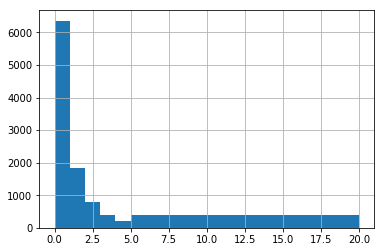

In [1017]:
(data.number_outpatient + data.number_inpatient + data.number_emergency).hist(bins=[0, 1, 2, 3, 4,5, 20])

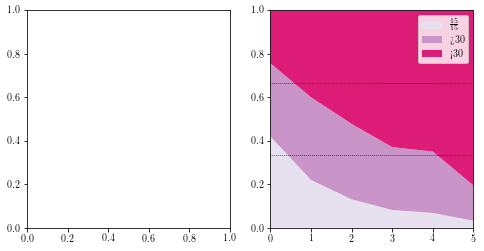

In [1228]:
visits_counts_no = np.minimum(5, (np.minimum(4,data.loc[data.readmitted ==  'NO'].number_inpatient)+ np.minimum(4,data.loc[data.readmitted ==  'NO'].number_outpatient) + np.minimum(4,data.loc[data.readmitted ==  'NO'].number_emergency))).value_counts()
visits_counts_gt = np.minimum(5, (np.minimum(4,data.loc[data.readmitted == '>30'].number_inpatient)+ np.minimum(4,data.loc[data.readmitted == '>30'].number_outpatient) + np.minimum(4,data.loc[data.readmitted == '>30'].number_emergency))).value_counts()
visits_counts_lt = np.minimum(5, (np.minimum(4,data.loc[data.readmitted == '<30'].number_inpatient)+ np.minimum(4,data.loc[data.readmitted == '<30'].number_outpatient) + np.minimum(4,data.loc[data.readmitted == '<30'].number_emergency))).value_counts()

fig, axes = plt.subplots(1,2, figsize=(8,4))

visits_freqs = np.sum([visits_counts_gt, visits_counts_lt, visits_counts_no], axis=0)
axes[1].stackplot(range(0,60,10), visits_counts_no / visits_freqs, visits_counts_gt / visits_freqs, visits_counts_lt / visits_freqs, colors=["#e7e1ef","#c994c7","#dd1c77"], labels=[r'$\frac{15}{15}$', '>30', '<30'])
axes[1].set_xticks(range(0,60,10))
axes[1].set_xticklabels(visits_counts_no.keys(), rotation=0)
axes[1].plot([0,56], [1/3, 1/3], 'k:', linewidth=0.75)
axes[1].plot([0,56], [2/3, 2/3], 'k:', linewidth=0.75)
axes[1].set_ylim(0,1)
axes[1].set_xlim(0,50)
axes[1].legend(loc='upper right')

<BarContainer object of 5 artists>

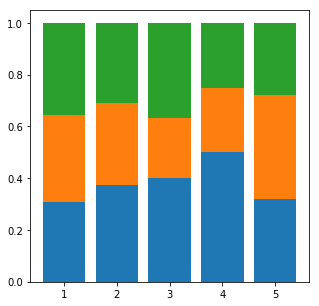

In [1073]:
adno = data.loc[data.readmitted == 'NO'].admission_type_id.value_counts()
adgt = data.loc[data.readmitted == '>30'].admission_type_id.value_counts()
adlt = data.loc[data.readmitted == '<30'].admission_type_id.value_counts()
ad = (adno,adgt,adlt)
for c in (adno,adgt,adlt):
    for i in range(1,9):
        if not i in c.index:
            c[i] = 0
adno = adno.sort_index()
adgt=adgt.sort_index()
adlt=adlt.sort_index()

addno = np.zeros(5)
addno[:4] = adno[:4]
addno[4] = adno[4:].sum()
addgt = np.zeros(5)
addgt[:4] = adgt[:4]
addgt[4] = adgt[4:].sum()
addlt = np.zeros(5)
addlt[:4] = adlt[:4]
addlt[4] = adlt[4:].sum()

add = np.array([addno, addgt, addlt])

norm = add.sum(axis=0)

fig, ax = plt.subplots(figsize=(5,5))

ax.bar(range(1,6), addno/norm)
ax.bar(range(1,6), addgt/norm, bottom=addno/norm)
ax.bar(range(1,6), addlt/norm, bottom=addno/norm+addgt/norm)

In [1140]:
data.loc[data.max_glu_serum != 'None'].sample(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,raceandgender
4522,25395828,23578182,Caucasian,Male,[70-80),NaN,5,6,17,2,NaN,Urology,20,1,14,0,0,0,600,599,596,7,Norm,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,<30,CaucasianMale
7464,37747836,23861169,Caucasian,Male,[70-80),NaN,1,5,17,2,NaN,Family/GeneralPractice,24,0,8,4,0,0,434,401,433,8,Norm,None,Steady,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,>30,CaucasianMale
9456,81369540,23398668,Caucasian,Female,[80-90),NaN,6,25,17,2,NaN,NaN,25,0,11,0,1,0,786,428,396,9,>200,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,<30,CaucasianFemale
253,2926554,86209290,Caucasian,Female,[70-80),NaN,6,1,1,7,NaN,NaN,37,2,9,0,0,1,V57,157,250.02,3,Norm,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,CaucasianFemale
7816,44583066,27797625,Caucasian,Female,[70-80),NaN,5,1,17,3,NaN,Cardiology,18,2,15,0,0,0,427,426,250.6,5,Norm,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30,CaucasianFemale
7149,35842572,26064999,Caucasian,Female,[70-80),NaN,1,3,17,2,NaN,NaN,24,0,12,0,0,0,428,250.01,414,6,Norm,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,CaucasianFemale
5756,29474658,23874201,Caucasian,Female,[70-80),NaN,5,6,17,5,NaN,NaN,18,0,15,0,0,0,250,486,276,8,>300,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,CaucasianFemale
5236,27718092,23633154,Caucasian,Male,[70-80),NaN,1,1,17,1,NaN,NaN,17,0,8,1,0,0,250.6,536,8,7,Norm,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,CaucasianMale
3603,22036146,25836687,Caucasian,Male,[80-90),NaN,5,1,17,1,NaN,Cardiology,22,0,7,0,0,0,515,486,401,8,Norm,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30,CaucasianMale
5520,28590270,23513400,Caucasian,Male,[40-50),NaN,5,2,17,1,NaN,Cardiology,22,0,11,1,0,1,786,250,278,8,>300,None,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,>30,CaucasianMale


In [1086]:
change_counts_lt = data.loc[data.readmitted=='<30'].change.value_counts().sort_index()[[2,3,0,1]]
change_counts_gt = data.loc[data.readmitted=='>30'].change.value_counts().sort_index()[[2,3,0,1]]
change_counts_no = data.loc[data.readmitted=='NO'].change.value_counts().sort_index()[[2,3,0,1]]
change_counts = change_counts_no + change_counts_gt + change_counts_lt
norm_change = change_counts.sum()
change_counts_gt /= norm_change; change_counts_lt /= norm_change; change_counts_no /= norm_change
change_counts /= norm_change

0.012901290129012902

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab94c617f0>,
      dtype=object)

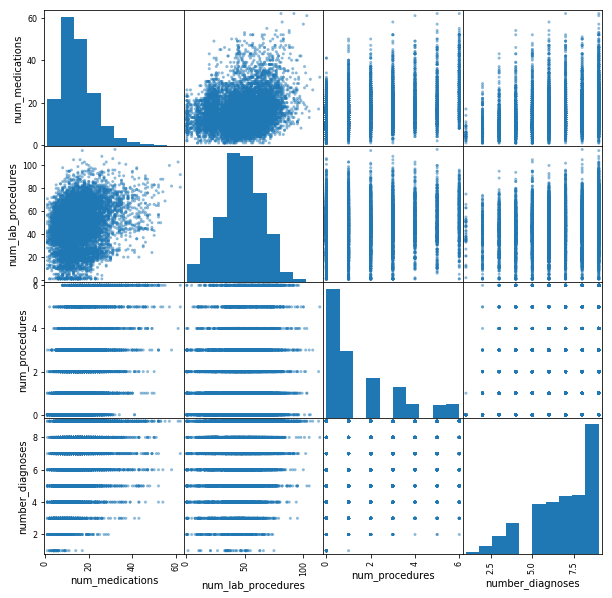

In [1098]:
numerics = ['num_medications', 'num_lab_procedures', 'num_procedures', 'number_diagnoses']
from pandas.plotting import scatter_matrix as splom
splom(data[numerics], figsize=(10,10))

In [1133]:
def interpret_diagnosis(diag):
    if (type(diag) == float and np.isnan(diag)) or diag == "NaN":
        return np.nan
    try:
        num = int(diag)
    except Exception as e:
        if diag[0] == 'E':
            return "SUPP_CLASS_EXTERNAL_CAUSE"
        elif diag[0] == 'V':
            return "SUPP_CLASS_HEALTH_FACTORS"
        else:
            try:
                num = float(diag)
                return "DIABETES"
            except Exception as ex:
                return "ERROR"
    if (num >= 390 and num <= 459) or num == 785:
        return "CIRCULATORY"
    elif (num >= 460 and num <= 519) or num == 786:
        return "RESPIRATORY"
    elif (num >= 520 and num <= 579) or num == 787:
        return "DIGESTIVE"
    elif num >= 800: 
        return "INJURY_OR_POISON"
    elif num >= 710 and num <= 739:
        return "MUSKOSKELETAL"
    elif (num >= 580 and num <= 629) or num == 788:
        return "GENITOURINARY"
    elif num >= 140 and num <= 239:
        return "NEOPLASMS"
    elif num >= 680 and num <= 709:
        return "SKIN"
    elif num >= 780 and num <= 799:
        return "ILL-DEFINED"
    elif num <= 139:
        return "INFECTIOUS_PARASITIC"
    elif num >= 240 and num <= 279:
        return "ENDOCRINE_METABOLIC"
    elif num >= 290 and num <= 319:
        return "MENTAL_DISORDER"
    elif num >= 630 and num <= 679:
        return "PREGNANCY_COMPLICATIONS"
    elif num >= 280 and num <= 289:
        return "BLOOD"
    elif num >= 320 and num <= 389:
        return "NERVOUS_SENSE"
    elif num >= 740 and num <= 759:
        return "CONGENITAL"
    else: 
        return "ERROR"

    
    
print(len(data.diag_1.map(interpret_diagnosis).value_counts()))
print()
print(len(data.diag_2.map(interpret_diagnosis).value_counts()))
print()
print(len(data.diag_3.map(interpret_diagnosis).value_counts()))
print()


18

19

19



In [1141]:
data.medical_specialty.value_counts()/len(data)

InternalMedicine                        0.197420
Family/GeneralPractice                  0.128113
Cardiology                              0.086609
Surgery-General                         0.034303
Nephrology                              0.020902
Orthopedics-Reconstructive              0.020302
Psychiatry                              0.017202
Pulmonology                             0.016002
Orthopedics                             0.013201
Surgery-Cardiovascular/Thoracic         0.011701
Urology                                 0.011501
ObstetricsandGynecology                 0.010701
PhysicalMedicineandRehabilitation       0.007701
Hematology/Oncology                     0.007701
Surgery-Neuro                           0.006401
Pediatrics-Endocrinology                0.006301
Emergency/Trauma                        0.006301
Gastroenterology                        0.006301
Pediatrics                              0.004900
Pediatrics-CriticalCare                 0.004600
Endocrinology       

In [1224]:
data.A1Cresult = data.A1Cresult.map({'None': 'None', 'Norm': 'Norm', '>7':'7-8', '>8':'8+'})

In [1214]:
data.max_glu_serum.value_counts()

None       8948
Norm        431
200-300     272
300+        219
Name: max_glu_serum, dtype: int64

In [85]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'booleanGlucose', 'discharge_disposition_cat', 'admission_source_cat',
       'admiss

In [89]:
data.patient_nbr.value_counts().value_counts()[3:].sum()/len(data)

0.017538429794697205

In [90]:
data.weight.value_counts()

[75-100)     119
[50-75)       84
[100-125)     37
[0-25)        20
[25-50)       12
[125-150)      6
[150-175)      3
Name: weight, dtype: int64

In [424]:
fulldata = pd.read_csv("diabetes/diabetic_data_original.csv")
fulldata.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [118]:
print(data.readmitted.value_counts())
print()
print(len(data)/9999)
print()
print(data.readmitted.value_counts()/len(data))

>30    3290
<30    3282
NO     3121
Name: readmitted, dtype: int64

0.9693969396939695

>30    0.339420
<30    0.338595
NO     0.321985
Name: readmitted, dtype: float64


In [124]:
data.admission_source_cat.value_counts()

E.R.               5035
REFERRAL           2576
NULL               1368
TRANSFER            712
LAW_ENFORCEMENT       2
Name: admission_source_cat, dtype: int64

In [179]:
t = data.loc[data.booleanGlucose > 0]; len(t)/len(data)

0.09377901578458682

In [181]:
booleanTest = list(map(any, zip(data.booleanGlucose, data.A1Cresult != 'None')))

In [182]:
len(data.loc[booleanTest])/len(data)

0.27525018054265965

In [184]:
len(data.loc[data.booleanGlucose > 0])/len(data)

0.09377901578458682

In [190]:
"a".replace(' ', '\n')da

'a'

In [206]:
data.discharge_disposition_cat.value_counts()

Care Continues Elsewhere    5884
ICF/SNF                     1466
Further Care at Home        1187
NULL                        1094
Left A.M.A.                   61
Care Continues Here            1
Name: discharge_disposition_cat, dtype: int64

In [300]:
from tqdm import tqdm_notebook as tqdm
tmp = data.diag_1.append(data.diag_2.append(data.diag_3)).value_counts().value_counts().sort_index()
tmp2 = {j:tmp[i:].sum() for i, j in enumerate(tmp.index)}
idx = np.arange(1, tmp.index.max()+1)
tmp3 = []
for i in tqdm(idx):
    print(tmp2[i] if i in tmp.index else tmp3[-1])
    tmp3.append(tmp2[i] if i in tmp.index else tmp3[-1])

623
475
417
371
331
308
288
267
255
246
240
232
229
217
207
203
198
189
185
179
173
169
167
160
156
153
147
145
144
142
142
137
135
135
129
128
125
122
121
118
116
115
113
109
107
102
102
100
98
97
96
96
96
94
94
93
93
92
88
87
87
86
85
84
84
83
82
80
80
79
79
78
77
76
75
73
73
73
73
73
73
72
71
70
70
68
66
66
66
66
66
66
66
65
64
61
61
59
58
58
58
57
56
56
56
56
56
56
56
56
56
56
55
55
55
53
53
52
52
52
52
52
51
50
50
49
49
49
49
49
49
48
47
47
47
47
47
47
46
46
46
45
45
45
44
44
43
43
43
43
42
41
41
41
40
40
40
39
39
39
39
38
38
38
38
38
37
37
37
37
37
36
36
36
36
36
36
36
36
36
36
35
33
33
32
32
32
32
32
32
32
32
31
31
31
30
30
30
30
30
30
30
30
30
30
29
29
29
28
28
28
28
28
27
27
27
27
27
27
26
26
26
26
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
24
24
24
24
24
24
24
24
24
24
24
24
23
23
23
23
23
23
23
23
23
23
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
21
21
21
21
21
21
21
21
21
21
21
21
21
21
20
20
20
20
20
2

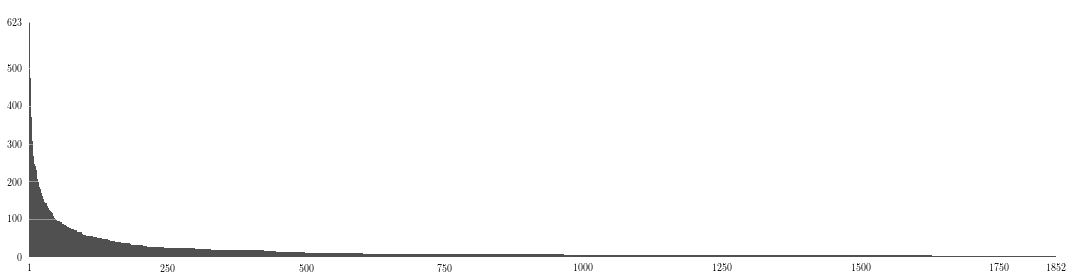

In [322]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.bar(idx, tmp3, width=1, fc='#505050')
#    ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='both', color='white', grid_color='black', grid_alpha=1)
ax.grid(which='major', color='w', linestyle='-', axis='y', alpha=0.5)
ax.set_xticks([min(idx),250,500,750,1000,1250,1500,1750,idx.max()])
ax.set_yticks([0, 100,200,300,400,500,max(tmp3)])
plt.xlim(0, len(tmp3))
fig.tight_layout()
plt.savefig('diag_dist.pdf')


In [292]:
data.diag_1

49

In [282]:
len(data.medical_specialty.value_counts())

49

In [341]:
tmp3.index(16)

424

In [339]:
tmp = data.diag_1.append(data.diag_2.append(data.diag_3)).map(cat).value_counts()

In [342]:
len(tmp)

20

In [360]:
idx = [True for _ in range(22)]
idx[16] = False
generics[((data[generics].values == 'No').mean(axis=0)[idx]).argmin()]


'metformin'

In [363]:
(data[generics].values == 'No').sum(axis=1).min()

16

In [387]:
np.linalg.norm

<function numpy.linalg.norm(x, ord=None, axis=None, keepdims=False)>

<IPython.core.display.Javascript object>


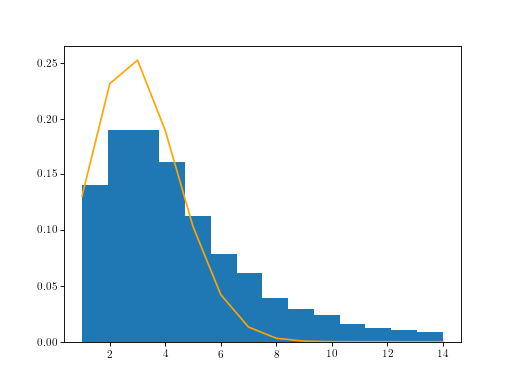

(array([0.14062733, 0.190117  , 0.18959422, 0.16118994, 0.11239731,
        0.07893951, 0.06203635, 0.03955688, 0.02979836, 0.02439632,
        0.01620612, 0.01219816, 0.01097834, 0.00888723]),
 array([ 1.        ,  1.92857143,  2.85714286,  3.78571429,  4.71428571,
         5.64285714,  6.57142857,  7.5       ,  8.42857143,  9.35714286,
        10.28571429, 11.21428571, 12.14285714, 13.07142857, 14.        ]),
 <a list of 14 Patch objects>)

In [27]:
from scipy.stats import binom
%matplotlib notebook
rv = binom(14, 3/14)

plt.plot(np.arange(1,15), rv.pmf(np.arange(1,15)), c='orange', zorder=1)
plt.hist(data.time_in_hospital[data.num_procedures <= 1], bins=14, density=True)

In [ ]:
plt.hist